In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error

from utils.train import create_dataloader, train
from models import cLSTM

In [2]:
# this center aligns all figures

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Load/Process Data:

The `WindowDataset` class is a subclass of `TensorDataset` in PyTorch. It creates a 'windowed' dataset from input data, in which each input-output pairs consists of a window of data as the input and the subsequent element as the output.

In [3]:
class WindowDataset(TensorDataset):
    def __init__(self, data, window_size=4):
        self.data = data.astype('float64')
        self.window_size = window_size
 
    def __getitem__(self, idx):
        ind = ((idx+1) // (100-self.window_size*10))*(self.window_size*10) + idx
        sample_input = torch.tensor(self.data[ind:ind+self.window_size*10:10])      
        sample_output = torch.tensor(self.data[ind+self.window_size*10])
        return sample_input[:,None,:], sample_output[None,:,:]

    def __len__(self):
        return len(self.data) - 125 * (self.window_size*10) - self.window_size*10

In [4]:
batch_size = 32 # same batch size for train and val

train_path = 'data/Ferguson_fire_train.npy'
train_data = np.load(train_path)
train_dataset = WindowDataset(train_data, window_size=3)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_path = 'data/Ferguson_fire_test.npy'
val_data = np.load(val_path)
val_dataset = WindowDataset(val_data, window_size=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Train (ConvLSTM) Model:

The `train` function trains the model using MSE loss and the Adam optimizer for the specified number of epochs. 

It includes early stopping based on the validation loss, with a default patience of 3.

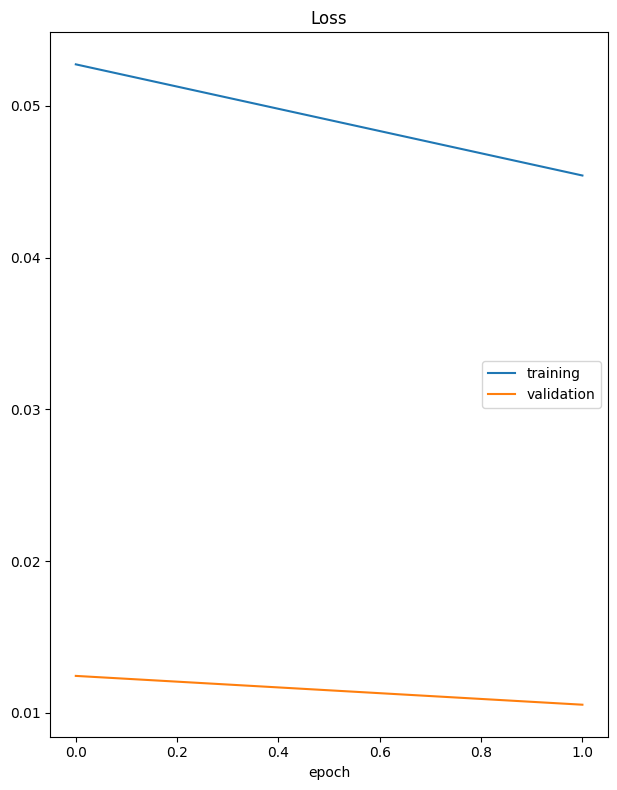

Loss
	training         	 (min:    0.045, max:    0.053, cur:    0.045)
	validation       	 (min:    0.011, max:    0.012, cur:    0.011)
Epoch 3 of 20
Train:


100%|███████████████████████████████████████| 273/273 [6:39:21<00:00, 87.77s/it]


Val:


 15%|██████▊                                     | 6/39 [00:22<02:00,  3.65s/it]

In [ ]:
device = 'cpu'
epochs = 20

channels = 1
clstm = cLSTM.ConvLSTM(input_dim=channels, hidden_dim=16, kernel_size=(3, 3), num_layers=1, batch_first=True, return_all_layers=False).to(device)

# loads model from saved weights if found, else trains from scratch
if not os.path.exists('models/weights/clstm.pt'):
    clstm = train(clstm, train_loader, val_loader, epochs=epochs, device=device)
    if not os.path.exists('models/weights'):
        os.makedirs('models/weights')
    torch.save(clstm.state_dict(), 'models/weights/clstm.pt')
else:
    clstm.load_state_dict(torch.load('models/weights/clstm.pt', map_location=torch.device('cpu')))

### Plot validation results (actual vs forecasted):

In [ ]:
images, labels = next(iter(test_loader))
clstm.eval()

fig, ax = plt.subplots(2, 5, figsize=[18.5, 6])
fig.tight_layout(pad=4)
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
    _, recon = clstm(images[idx].unsqueeze(0).float())
    ax[0, n].imshow(labels[idx].squeeze())
    ax[0, n].axis('off')
    ax[1, n].imshow(recon.cpu().detach().squeeze())
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Val) Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('(Val) Forecasted:', fontsize=20, pad=20, loc='left')

### Plot test results (actual vs forecasted):

In [ ]:
# load test (i.e. observation) data

test_path = 'data/Ferguson_fire_obs.npy'
test_data = np.array(np.load(open(test_path,'rb')))
test_data = test_data.reshape(1, test_data.shape[0], 1, test_data.shape[1], test_data.shape[2])
x = np.array([test_data[:,0:3,:,:,:], test_data[:,1:4,:,:,:]])
y = np.array([test_data[:,3,:,:,:], test_data[:,4,:,:,:]])

test_dataset = TensorDataset(torch.Tensor(x),torch.Tensor(y))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[5, 5])
fig.tight_layout(pad=1)
mses = []

for n,(image, label) in enumerate(obs_dataset):
    _, recon = clstm(image.double()) 
    mses.append(mean_squared_error(label.flatten(),recon.cpu().detach().squeeze().flatten()))
    ax[0, n].axis('off')
    ax[0, n].imshow(label.squeeze())
    ax[1, n].imshow(recon.cpu().detach().squeeze())
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Test) Actual:', fontsize=16, pad=10, loc='left')
        ax[1,n].set_title('(Test) Forecasted:', fontsize=16, pad=10, loc='left')

### MSE test:

Below is the MSE between the (observed) satellite data and the model's forecasts. 

In [ ]:
print(f'(Test) MSE: {sum(mses)/len(obs_dataset)}')